# Combine Astor, Chambers, Twenty Twenty, Wine
Clean and format all data from the four sites<br>
Create vintage columns or bottle_size for data if possible<br>
Deal with missing values: some initial cleaning has been done in individual notebooks after the scraping.<br>
Used list comprehension to do initial cleaning on data since each set is formatted differently. 

In [1]:
import pandas as pd
import numpy as np
import regex as re
import nltk
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import collections
from collections import Counter

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup

### Import Astor, Chambers, Twenty Twenty, Wine

In [2]:
astor = pd.read_csv('../data/astor_data/all_astor_df.csv')
astor.shape

(3182, 16)

In [3]:
chambers = pd.read_csv('../data/chambers_street/all_chambers_df.csv').drop(columns='Unnamed: 0')
chambers.shape

(944, 6)

In [4]:
twenty = pd.read_csv('../data/2020_wines/all_2020_df.csv')
twenty.shape

(510, 12)

In [5]:
wine = pd.read_csv('../data/wine_com/all_wine.csv')
wine.shape

(8273, 11)

### Clean Data
Rename and combine columns to concat the DataFrames 

### Astor

In [6]:
astor.head(1)

,name,producer,vintage,bottle_size,color,price,country,region,grape_1,tasting_notes,url,grape_2,grape_3,staff_tasting,sub_region,grape_5
0,"Skin Contact Silvaner ""Kleine Heimat,"" 2Naturk...",2Naturkinder,2017,750mL,White,$24.96,Germany,Franken,Silvaner,"Made from 100% Silvaner, this white wine ferme...",https://www.astorwines.com/SearchResultsSingle...,NaN,NaN,NaN,NaN,NaN


In [7]:
astor.shape

(3182, 16)

In [8]:
astor.isnull().sum()

name                0
producer            0
vintage             0
bottle_size         7
color               0
price             604
country             0
region             78
grape_1             0
tasting_notes      30
url                 0
grape_2          2342
grape_3          2737
staff_tasting    2209
sub_region       1375
grape_5          3148
dtype: int64

There are 30 rows that do not have `tasting_notes` or `staff_tasting` filled in the `name` for these missing values before combining these 2 columns. <br><br>
`staff_tasting` and `tasting_notes` need to be combined into one column for processing and it will be easier if all three DataFrames have the same column for text based description. Once combined, the other 2 columns were dropped. 

In [8]:
astor.loc[pd.isnull(astor['tasting_notes']), 'tasting_notes'] = astor['name']

In [9]:
astor['staff_tasting'].fillna('', inplace=True)

In [10]:
astor['description'] = astor['staff_tasting'].astype(str) + astor['tasting_notes'].astype(str)

Combine grape columns name of to `grape` to match Twenty Twenty DataFrame

In [11]:
astor['grape_2'].fillna('', inplace=True)
astor['grape_3'].fillna('', inplace=True)
# astor['grape_4'].fillna('', inplace=True) 
# there is no grape_4: Checked the wines that have grape_5 populated and grape_5 is the the 4th grape listed
astor['grape_5'].fillna('', inplace=True)

In [12]:
astor['grape'] = astor['grape_1'] +' '+ astor['grape_2'] +' '+ astor['grape_3'] +' '+ astor['grape_5']

Glera is the grape not prosecco. It has this listed as Prosecco(Glera), remove unwanted characters

In [14]:
astor['grape'] = [str(row).replace('Prosecco', '') for row in astor['grape']]
astor['grape'] = [str(row).replace('(', '') for row in astor['grape']]
astor['grape'] = [str(row).replace(')', '') for row in astor['grape']]

In [15]:
# get rid of whitespaces
astor['grape'] = [str(row).strip() for row in astor['grape']]

Madeira is not a country, it is a region of Portugal - made these corrections.

In [16]:
astor.loc[164:165, 'country'] = 'portugal'
astor.loc[164:165, 'region'] = 'madeira'
astor.loc[215:216, 'country'] = 'portugal'
astor.loc[215:216, 'region'] = 'madeira'
astor.loc[2924, 'country'] = 'portugal'
astor.loc[2924, 'region'] = 'madeira'

Change `sub_region` to `subregion` to match Twenty Twenty DataFrame

In [17]:
astor['subregion'] = astor['sub_region']

Drop columns that have been combined 

In [18]:
astor.drop(columns=['tasting_notes', 'staff_tasting', 
                    'grape_1', 'grape_2', 'grape_3', 'grape_5', 
                    'sub_region'], inplace=True)

There are 7 null values in `bottle_size` and is replaced with `0`.

In [19]:
astor['bottle_size'].fillna(0, inplace=True)

`region` has 78 null values and `subregion` has 1375. Replace with 0 for now.

In [20]:
astor['region'].fillna(0, inplace=True)
astor['subregion'].fillna(0, inplace=True)

`price` has 604 null values. If it is null, the item is currently out of stock and there is a 'Notify Me' button instead. These values will be changed to `0`<br>
Remove `$` and cents. Leave only whole dollar amount. 

In [21]:
astor['price'].fillna('0000', inplace=True)

In [22]:
# make sure this cell only runs once
astor['price'] = [str(row).lstrip('$') for row in astor['price']] 
astor['price'] = [str(row)[:-3].strip() for row in astor['price']]
# astor['price'] = [str(row).rstrip('.') for row in astor['price']]
# astor['price'] = [re.sub('[^0123456789\.]','', row) for row in astor['price']]

Remove '- vintage' from `name` 

In [23]:
astor['name'] = [str(row).rstrip('1234567890').strip() for row in astor['name']]
astor['name'] = [str(row).replace('-', '').strip() for row in astor['name']]

Get rid of escape characters for `description`

In [24]:
astor['description'] = [" ".join(str(row).split()) for row in astor['description']]

In [25]:
astor['bottle_size'] = [str(row).rstrip('mL').strip() for row in astor['bottle_size']]

In [26]:
astor['color'].value_counts()

Red      1778
White    1211
Rosé      118
Amber      74
red         1
Name: color, dtype: int64

Drop ciders

In [27]:
cider_astor = astor[astor['name'].str.contains('Cider')].index
astor.drop(cider_astor, inplace=True)

In [28]:
pd.set_option('display.max_rows', None)
# pd.reset_option('max_rows')

`color` assign to either red, white, rose, other, sparkling. Find sparklings. Other contains fortified and dessert wines. 

In [29]:
astor_amber = astor[astor['color'] == 'Amber'].index
astor.loc[astor_amber, 'color'] = 'other'

In [30]:
astor_brut = astor[astor['name'].str.contains('brut', flags=re.IGNORECASE)].index
astor.loc[astor_brut, 'color'] = 'sparkling'

In [31]:
astor_sparkling = astor[astor['name'].str.contains('sparkling', flags=re.IGNORECASE)].index
astor.loc[astor_sparkling, 'color'] = 'sparkling'

In [32]:
# this is fine all will be lowercased later
astor['color'].value_counts()

Red          1776
White         996
sparkling     246
Rosé           78
other          72
red             1
Name: color, dtype: int64

In [33]:
astor.isnull().sum()

name           0
producer       0
vintage        0
bottle_size    0
color          0
price          0
country        0
region         0
url            0
description    0
grape          0
subregion      0
dtype: int64

## Chambers
Do not remove producer or vintage from name as there is not a column for these<br>
Removed names of people who reveiw for Chambers as well as `\xa0` that reoccurs many reviews. 

In [34]:
chambers.head(1)

,name,color,price,description,url,country
0,Basket Range 2017 Adelaide Hills Red Blend,red,$30.99,Back in the 1980's Phil Broderick started pla...,https://www.chambersstwines.com/Products/70060...,australia


In [35]:
chambers.isnull().sum()

name             0
color            0
price            0
description    173
url              0
country          0
dtype: int64

Add a `vintage` column

In [36]:
chambers['vintage'] = chambers['name']

In [37]:
chambers['vintage'] = [re.sub('[^0123456789\.]','', row) for row in chambers['vintage']]
chambers['name'] = [re.sub('[0123456789\.]','', row) for row in chambers['name']]

Remove all whitespaces from `name`

In [38]:
chambers['name'] = [str(row).strip() for row in chambers['name']]

There are 173 missing `description` these are filled in the the `name` from the same row. <br>
192 rows have a blank spaces as `description`. Change these to null and fill in with `name`. 

In [39]:
# https://stackoverflow.com/questions/13445241/replacing-blank-values-white-space-with-nan-in-pandas
chambers = chambers.replace(r'^\s+$', np.nan, regex=True)

In [40]:
chambers.loc[pd.isnull(chambers['description']), 'description'] = chambers['name']

In [41]:
chambers['description'] = [str(row).replace('\xa0', '') for row in chambers['description']] 
chambers['description'] = [str(row).replace('Michelle DeWyngaert', '') for row in chambers['description']]
chambers['description'] = [str(row).replace('Cari Bernard', '') for row in chambers['description']]
chambers['description'] = [str(row).replace('John McIlwain', '') for row in chambers['description']]
chambers['description'] = [str(row).strip() for row in chambers['description']] # remove whitespace

Remove `$` and cents from `price`

In [42]:
# make sure this cell only runs once
# chambers['price'] = [str(row).lstrip('$') for row in chambers['price']] 
chambers['price'] = [str(row)[:-3].strip() for row in chambers['price']]
chambers['price'] = [re.sub('[^0123456789\.]','', row) for row in chambers['price']]

Israel was spelled incorrectly. Discovered this when counting number of countries per data set.

In [43]:
chambers['country'] = [str(row).replace('isreal', 'israel') for row in chambers['country']]

Drop ciders

In [44]:
cider_chambers = chambers[chambers['name'].str.contains('Cider', flags=re.IGNORECASE)].index
chambers.drop(cider_chambers, inplace=True)

Chambers does not include columns for producer, vintage, region, grape, subregion, bottle size. They include this information in `name`

In [45]:
chambers.isnull().sum()

name           0
color          0
price          0
description    0
url            0
country        0
vintage        0
dtype: int64

`color` assign to either red, white, rose, other, sparkling. Find sparklings. Other contains fortified and dessert wines. 

In [46]:
chambers_wspark = chambers[chambers['color'] == 'white sparkling'].index
chambers.loc[chambers_wspark, 'color'] = 'sparkling'

In [47]:
chambers_rspark = chambers[chambers['color'] == 'rosé sparkling'].index
chambers.loc[chambers_rspark, 'color'] = 'sparkling'

In [48]:
chambers_wsweet = chambers[chambers['color'] == 'white sweet'].index
chambers.loc[chambers_wsweet, 'color'] = 'other'

In [49]:
chambers_msweet = chambers[chambers['color'] == 'white medium-sweet'].index
chambers.loc[chambers_msweet, 'color'] = 'white'

In [50]:
chambers_od = chambers[chambers['color'] == 'white off-dry'].index
chambers.loc[chambers_od, 'color'] = 'white'

In [51]:
chambers_wf = chambers[chambers['color'] == 'white fortified'].index
chambers.loc[chambers_wf, 'color'] = 'other'

In [52]:
chambers_ms = chambers[chambers['color'] == 'red fortified medium-sweet'].index
chambers.loc[chambers_ms, 'color'] = 'other'

In [53]:
chambers_fs = chambers[chambers['color'] == 'red fortified sweet'].index
chambers.loc[chambers_fs, 'color'] = 'other'

In [54]:
chambers_rsp = chambers[chambers['color'] == 'red sparkling'].index
chambers.loc[chambers_rsp, 'color'] = 'sparkling'

In [55]:
chambers_wfor = chambers[chambers['color'] == 'white flor fortified'].index
chambers.loc[chambers_wfor, 'color'] = 'other'

In [56]:
chambers_rose = chambers[chambers['color'] == 'rosé '].index
chambers.loc[chambers_rose, 'color'] = 'rosé'

In [57]:
chambers_wfsw = chambers[chambers['color'] == 'white fortified sweet'].index
chambers.loc[chambers_wfsw, 'color'] = 'other'

In [58]:
chambers_odsp = chambers[chambers['color'] == 'white sparkling off-dry'].index
chambers.loc[chambers_odsp, 'color'] = 'sparkling'

In [59]:
chambers_rswe = chambers[chambers['color'] == 'red sweet'].index
chambers.loc[chambers_rswe, 'color'] = 'other'

In [60]:
chambers_rko = chambers[chambers['color'] == 'red kosher'].index
chambers.loc[chambers_rko, 'color'] = 'red'

In [61]:
chambers_wko = chambers[chambers['color'] == 'white kosher'].index
chambers.loc[chambers_wko, 'color'] = 'white'

In [62]:
chambers_rods = chambers[chambers['color'] == 'red off-dry sparkling'].index
chambers.loc[chambers_rods, 'color'] = 'sparkling'

In [63]:
chambers_rosesp = chambers[chambers['color'] == 'rosé sparkling sweet'].index
chambers.loc[chambers_rosesp, 'color'] = 'sparkling'

In [64]:
chambers['color'].value_counts()

red          511
white        255
sparkling     91
rosé          41
other         39
Name: color, dtype: int64

## Twenty Twenty

In [65]:
twenty.head(1)

,name,vintage,producer,grape,designation,color,region,subregion,price,review,url,country
0,2015 Kaiken Malbec Ultra (750ml),2015,Kaiken,Malbec,Ultra,Red,No,No,$26.00,OTH93\n\nJames Suckling\n ...,https://2020wines.com/2015-kaiken-malbec-ultra...,argentina


In [66]:
twenty.isnull().sum()

name             0
vintage          0
producer         0
grape            0
designation      0
color            0
region           0
subregion        0
price            0
review         139
url              0
country          0
dtype: int64

Wines with null values in `review` fill in with `name`. Change `review` to `description` to match other DataFrames.

In [67]:
twenty.loc[pd.isnull(twenty['review']), 'review'] = twenty['name']

In [68]:
twenty['description'] = twenty['review']

Dropped `review` as `description` now has that same information. <br>
Remove the whitespace in the reviews. <br>
`designation` column does not have any information in it that is not in the `name`

In [69]:
twenty.drop(columns=['review', 'designation'], inplace=True)

In [70]:
twenty['description'] = [" ".join(str(row).split()) for row in twenty['description']]
twenty['description'] = [str(row).replace('OTH', '') for row in twenty['description']]
twenty['description'] = [str(row).replace('WA', '') for row in twenty['description']]
twenty['description'] = [str(row).replace('WS', '') for row in twenty['description']]
twenty['description'] = [str(row).replace('James Suckling', '') for row in twenty['description']]
twenty['description'] = [str(row).replace('Robert Parker', '') for row in twenty['description']]
twenty['description'] = [str(row).replace('James Halliday', '') for row in twenty['description']]
twenty['description'] = [str(row).replace('The Wine Advocate Reviewer', '') for row in twenty['description']]
twenty['description'] = [str(row).replace('Jay Miller', '') for row in twenty['description']]
twenty['description'] = [str(row).replace('The Wine Advocate', '') for row in twenty['description']]
twenty['description'] = [str(row).replace('Winery Notes', '') for row in twenty['description']]
twenty['description'] = [str(row).replace('Stephen Tanzer', '') for row in twenty['description']]
twenty['description'] = [str(row).replace('Wine Spectator', '') for row in twenty['description']]

In [71]:
twenty['description'][0]

"93  Beautiful aromas of roses, plums and blueberries. Subtle. Medium to full body, very fine tannins and a clean finish. Wonderful finesse and polish. Shows the elegance of the vintage in a very positive way. 90  This Malbec shows a beautiful deep ruby color with violet hues. On the nose, flowery and mineral notes are evident, with spicy touches that make the wine more complex and are finely blended with the elegance of the French oak. On the mouth, it's a wine of great structure and power – sweet plum, mocha and black cherry flavors blend with well-integrated oak and tannins that are both soft and present. It has an outstanding balance and a very long and polished finish."

Remove vintage and bottle size from name as these have their own columns in this DataFrame. 

Split off the `bottle_size` into it's own column and removed vintage from `name`

In [72]:
twenty['bottle_size'] = twenty['name']

In [73]:
# https://stackoverflow.com/questions/13215104/how-to-strip-trailing-digits-from-a-string
twenty['name'] = [re.sub('[0123456789\.]', '',row) for row in twenty['name']]
twenty['name'] = [str(row).rstrip('(ml)').strip() for row in twenty['name']]
twenty['bottle_size'] = [str(row).lstrip('1234567890') for row in twenty['bottle_size']]
twenty['bottle_size'] = [re.sub('[^0123456789\.]','', row) for row in twenty['bottle_size']]

`subregion` and `region` change `No` to `0` to match others 

In [74]:
twenty['subregion'] = [str(row).replace('No', '0') for row in twenty['subregion']]
twenty['region'] = [str(row).replace('No', '0') for row in twenty['region']]

Remove `$` and cents from `price`

In [75]:
# make sure this only runs once
twenty['price'] = [re.sub('[^0123456789\.]','', row) for row in twenty['price']]
twenty['price'] = [str(row)[:-3].strip() for row in twenty['price']]

In [76]:
# no cider
twenty[twenty['name'].str.contains('Cider', flags=re.IGNORECASE)]

,name,vintage,producer,grape,color,region,subregion,price,url,country,description,bottle_size


`color` assign to either red, white, rose, other, sparkling. Find sparklings. Other contains fortified and dessert wines. 

In [77]:
twenty['color'].value_counts()

Red          417
No            42
Sweet         31
Sparkling     18
White          2
Name: color, dtype: int64

In [78]:
twenty_other = twenty[twenty['color'] == 'No'].index
twenty.loc[twenty_other, 'color'] = 'other'

In [79]:
twenty.isnull().sum()

name           0
vintage        0
producer       0
grape          0
color          0
region         0
subregion      0
price          0
url            0
country        0
description    0
bottle_size    0
dtype: int64

## Wine.com
Do not remove producer or vintage from name as there is not a column for these

In [80]:
wine.head(1)

,name,grape,region,price,bottle_size,winemaker_notes,review,url,country,color,subregion
0,Josh Cellars Cabernet Sauvignon 2017,Cabernet Sauvignon,California,14,750,"Round and juicy, this Cabernet Sauvignon has f...","[<div class=""pipProfessionalReviews_review""><d...",https://www.wine.com/product/josh-cellars-cabe...,usa,red,NaN


In [81]:
wine.shape

(8273, 11)

In [82]:
wine.isnull().sum()

name                  0
grape                 0
region                0
price                 0
bottle_size           0
winemaker_notes    1491
review             3060
url                   0
country               0
color                 0
subregion          5016
dtype: int64

579 of values have null values in both `winemaker_notes` and `review`. Decided to fill in null `winemaker_notes` with `name` so there when they are combined there will be text in one of the columns. The `name` columns has good information that might normally be in a description so I feel comfortable filling in the null values this way. It is still information about the wine. 

In [13]:
wine[(wine['review'].isnull()) & (wine['winemaker_notes'].isnull())].shape

(579, 11)

In [84]:
wine.loc[pd.isnull(wine['winemaker_notes']), 'winemaker_notes'] = wine['name']

In [85]:
wine[wine['name'] == 'Fernando de Castilla Antique Amontillado Sherry']

,name,grape,region,price,bottle_size,winemaker_notes,review,url,country,color,subregion
8001,Fernando de Castilla Antique Amontillado Sherry,Sherry,"Jerez, Spain",45,500,The solera of the Antique Fino is used to feed...,"[<div class=""pipProfessionalReviews_review""><d...",https://www.wine.com/product/fernando-de-casti...,spain,sherry,NaN


While scraping data, I notices some consistent notations in France that are repeated in other columns-remove these<br>
<em>Not used by may decide to use later</em>

In [86]:
# wine['name'] = [str(row).replace('(Futures Pre-Sale)', '') for row in wine['name']]
# wine['name'] = [str(row).replace('(1.5 Liter Magnum)', '') for row in wine['name']]
# wine['name'] = [str(row).replace('(3 Liter Bottle)', '') for row in wine['name']]
# wine['name'] = [str(row).replace('(6-Pack OWC Futures Pre-Sale)', '') for row in wine['name']]
# wine['name'] = [str(row).replace('(1.5 Liter Futures Pre-Sale)', '') for row in wine['name']]
# wine['name'] = [str(row).replace('(6 Liter Bottle)', '') for row in wine['name']]

The way that `reviews` and `winemaker_notes` are formatted there is a lot that needs to be removed. 

In [87]:
wine['review'] = [str(row).replace('<div class="pipSecContent_copy">', '') for row in wine['review']]
wine['review'] = [str(row).rstrip('</p></div></div>]') for row in wine['review']]
wine['review'] = [str(row).replace('</div></div>', '') for row in wine ['review']]
wine['review'] = [str(row).replace('<div class="pipProfessionalReviews_review"><div class="pipSecContent_copy"><p>', '') for row in wine ['review']]
wine['review'] = [str(row).replace('OMMENTARY', '') for row in wine ['review']]
wine['review'] = [str(row).replace('TASTING NOTES', '') for row in wine ['review']]
wine['review'] = [str(row).replace('<div class="pipProfessionalReviews_review">', '') for row in wine['review']]

In [88]:
wine.loc[470, 'review']

'[A blend of 75% Cabernet Sauvignon, 14% Merlot, 6% Cabernet Franc and 5% Petit Verdot, the 2015 La Joie features a very deep purple-black color and almost electric nose of crushed blackcurrants, ripe black cherries and mulberries with sparks of raspberry pie, wild blueberries, unsmoked cigars, charcuterie and crushed stones. Medium to full-bodied and charged with the most amazing energy, the youthful, vibrant black-fruited palate is framed by very firm, very finely grained tannins and wonderful freshness, finishing with lingering crushed stones and earth layers. 4,000 cases produced., Never any question that this is a wine built with impact and seduction in mind. It’s so cleverly constructed that you almost don’t notice how it contracts as the tannins take hold, drawing out the whole experience. Clear elegance with tiny kicks of minerality that pulse and lift upwards through the palate, setting the rich cassis fruit alive. 75% Cabernet Sauvignon, 14% Merlot, 7% Cabernet Franc, 4% Peti

In [89]:
wine['description'] = wine['review'] + '' + wine['winemaker_notes']

In [90]:
wine.drop(columns=['winemaker_notes', 'review'], inplace=True)

In [91]:
wine['description'] = [str(row).lstrip('nan') for row in wine['description']]
wine['description'] = [str(row).lstrip('<p>') for row in wine['description']]

Add vintage column

In [92]:
wine['vintage'] = wine['name']

In [93]:
# only run once! 
wine['vintage'] = [re.sub('[^0123456789\.]','', row) for row in wine['vintage']]
# wine['vintage'] = wine['vintage'].str[-4:]

Because `vintage` was added, remove it from `name`

In [94]:
wine['name'] = [str(row).rstrip('1234567890').strip() for row in wine['name']]

Remove any puctuation from `price`

In [95]:
wine['price'] = [re.sub('[^0123456789\.]','', row) for row in wine['price']]

Drop cider

In [96]:
cider_wine = wine[wine['name'].str.contains('Cider', flags=re.IGNORECASE)].index
wine.drop(cider_wine, inplace=True)

`color` assign to either red, white, rose, other, sparkling. Find sparklings. Other contains fortified and dessert wines. 

In [97]:
wine_sherry = wine[wine['color'] == 'sherry'].index
wine.loc[wine_sherry, 'color'] = 'other'

In [98]:
wine['color'].value_counts()

red          5517
white        2031
sparkling     504
rose          180
other          40
Name: color, dtype: int64

In [99]:
# subregion is fine to be null-will change to 0 below
wine.isnull().sum()

name              0
grape             0
region            0
price             0
bottle_size       0
url               0
country           0
color             0
subregion      5015
description       0
vintage           0
dtype: int64

In [100]:
# still have vintage to clean up 
wine['vintage'].value_counts()

2017          1896
2018          1632
2016          1492
2015           872
2014           446
2013           262
2019           237
               193
2012           141
2011            58
3752017         52
1.52017         49
2010            47
.2017           46
.2016           45
2009            38
1.52016         38
.2018           38
3752018         32
3752016         31
1.52018         30
1.52015         28
.2015           26
..2017          24
62018           21
.2014           19
1.52014         17
2007            16
..2018          16
3752015         14
2006            12
375             12
2008            12
2001            11
1.52012         10
2000            10
32016           10
412016          10
..2015           9
2005             9
..2016           8
2002             8
1.52009          7
2003             6
32017            6
1.52013          6
3752019          5
3752007          5
2004             4
3752009          4
42018            4
1                4
72017       

# Concat DataFrames

In [101]:
all_wines = pd.concat([astor, chambers, twenty, wine])
# all_wines.to_csv('../data/all_wines.csv', index=False)
all_wines.isnull().sum()

name              0
producer       9209
vintage           0
bottle_size     937
color             0
price             0
country           0
region          937
url               0
description       0
grape           937
subregion      5952
dtype: int64

#### Null Values: 
`producer` null values are from Chambers and Wine.com. This information is contained in their `name` column.<br>
`subregion` null values are from Chambers and Wine.com. For Chambers, this is often found in the `name` and wine if it is listed, it is in `region`<br>
`bottle_size`, `region`, `grape` null values are from Chambers. This information is found in `descrption` and `name`. `bottle_size` is not listed on the site<br>

In [102]:
# can wines, box wines, NV sparkling
all_wines[all_wines['vintage'].isnull()]

,name,producer,vintage,bottle_size,color,price,country,region,url,description,grape,subregion


In [103]:
all_wines.fillna(0, inplace=True)

In [104]:
print('chambers', chambers.shape)
print('astor', astor.shape)
print('wine', wine.shape)
print('twenty twenty', twenty.shape)

chambers (937, 7)
astor (3169, 12)
wine (8272, 11)
twenty twenty (510, 12)


### Looking at Country, Price, Color trends
Astor has the largest representation of counties at 35. Each site has the greatest amount of wine from France which was expected. Found that a spelling error that was double counting Israel-corrected that above. 

In [166]:
print('astor', len(astor['country'].unique()))
print('chambers', len(chambers['country'].unique()))
print('twenty twenty', len(twenty['country'].unique()))
print('wine', len(wine['country'].unique()))
print('all wines', len(all_wines['country'].unique()))

astor 37
chambers 17
twenty twenty 9
wine 6
all wines 53


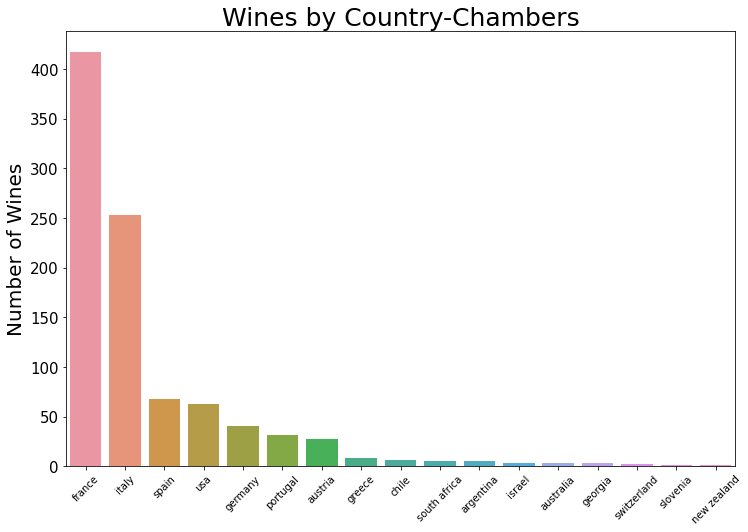

In [157]:
x = chambers['country'].value_counts()
y = x.sort_index()
plt.figure(figsize=(12,8))
chart = sns.barplot(x.index, x.values);
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);
plt.title('Wines by Country-Chambers', fontsize=25);
plt.ylabel('Number of Wines', fontsize=20);
plt.yticks(fontsize=15);
# plt.xlabel('Country', fontsize=20);
plt.xticks(fontsize=10);

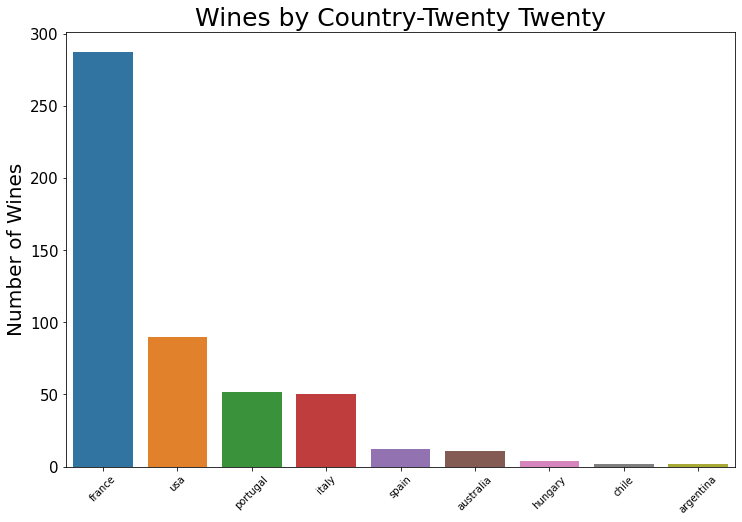

In [158]:
x = twenty['country'].value_counts()
y = x.sort_index()
plt.figure(figsize=(12,8))
chart = sns.barplot(x.index, x.values);
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);
plt.title('Wines by Country-Twenty Twenty', fontsize=25);
plt.ylabel('Number of Wines', fontsize=20);
plt.yticks(fontsize=15);
# plt.xlabel('Country', fontsize=20);
plt.xticks(fontsize=10);

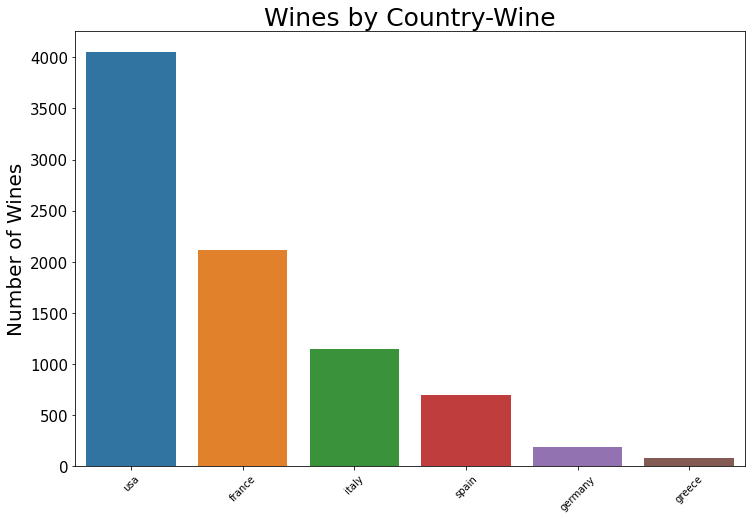

In [159]:
x = wine['country'].value_counts()
y = x.sort_index()
plt.figure(figsize=(12,8))
chart = sns.barplot(x.index, x.values);
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);
plt.title('Wines by Country-Wine', fontsize=25);
plt.ylabel('Number of Wines', fontsize=20);
plt.yticks(fontsize=15);
# plt.xlabel('Country', fontsize=20);
plt.xticks(fontsize=10);

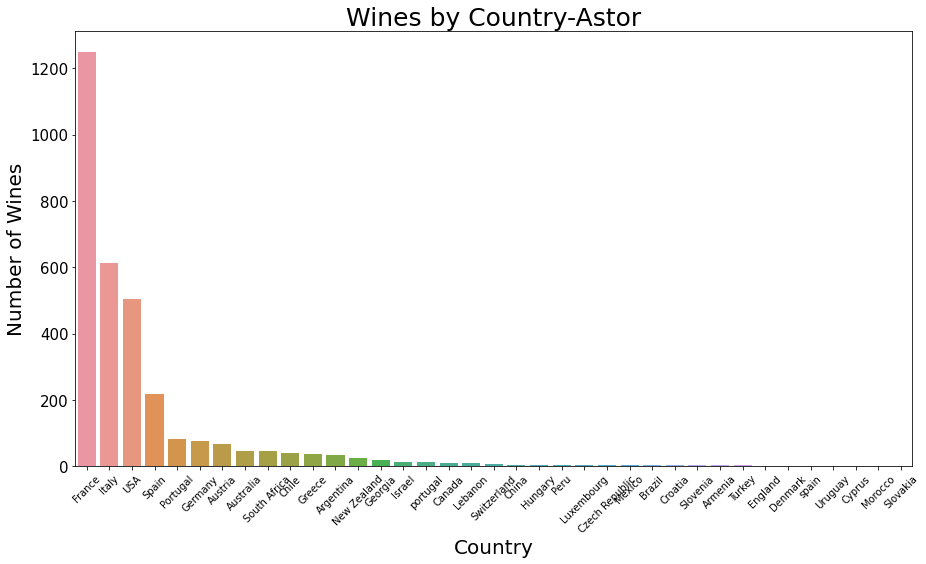

In [110]:
x = astor['country'].value_counts()
y = x.sort_index()
plt.figure(figsize=(15,8))
chart = sns.barplot(x.index, x.values);
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);
plt.title('Wines by Country-Astor', fontsize=25);
plt.ylabel('Number of Wines', fontsize=20);
plt.yticks(fontsize=15);
# plt.xlabel('Country', fontsize=20);
plt.xticks(fontsize=10);

In [161]:
# brough csv in from flask app folder
data_modeled = pd.read_csv('../app/for_flask.csv')

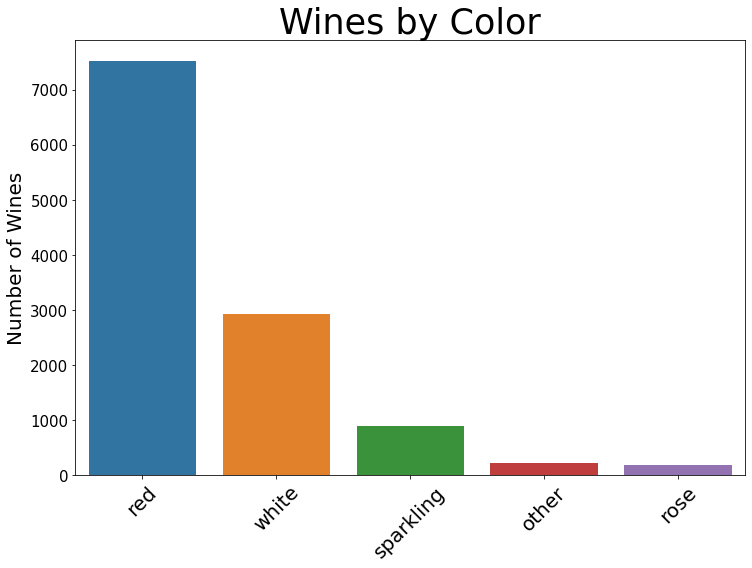

In [163]:
x = data_modeled['color'].value_counts()
y = x.sort_index()
plt.figure(figsize=(12,8))
chart = sns.barplot(x.index, x.values);
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);
plt.title('Wines by Color', fontsize=35);
plt.ylabel('Number of Wines', fontsize=20);
plt.yticks(fontsize=15);
# plt.xlabel('Color', fontsize=20);
plt.xticks(fontsize=20);

# Adjust these with full data
Looking at the price of wines, the average is \\$89 but this also includes wines that are greater than \\$500 with the most expensive bottle being \\$21,999. To see a better distribution of the price, the range is stopped at \\%500 . The average price of wine that is less than $500 but greater than \\$0 (null values) is \\$61

In [114]:
all_wines['price'] = all_wines['price'].astype(int)

In [115]:
all_wines['price'].mean()

95.18722842954686

In [182]:
all_wines.loc[4032]

name                     Underwood Cellars Pinot Gris (375ML Wine Can)
producer                                                             0
vintage                                                            375
bottle_size                                                        375
color                                                            white
price                                                                6
country                                                            usa
region                                       willamette valley, oregon
url                  https://www.wine.com/product/underwood-cellars...
description          This is the most approachable and ready-to-tra...
grape                                                pinot gris/grigio
subregion                                                            0
description_clean    approachable ready travel anywhere wine produc...
country_clean                                                      usa
text  

In [177]:
all_wines['price'].sort_values()

2193        0
3005        0
724         0
3004        0
3003        0
3002        0
1985        0
1364        0
2994        0
733         0
2990        0
2989        0
2984        0
1994        0
1360        0
741         0
742         0
743         0
2004        0
2015        0
747         0
750         0
2963        0
752         0
3006        0
3007        0
3008        0
716         0
3075        0
3073        0
1941        0
3068        0
1943        0
3057        0
3056        0
1377        0
688         0
3049        0
692         0
753         0
694         0
1955        0
3042        0
3041        0
699         0
700         0
702         0
1958        0
707         0
3017        0
3016        0
1984        0
695         0
3076        0
2962        0
756         0
803         0
804         0
806         0
2875        0
1344        0
1343        0
812         0
813         0
2053        0
2856        0
2851        0
2054        0
2837        0
2835        0
2832        0
2075  

In [143]:
all_wines['price'].max()

21999

In [147]:
all_wines[all_wines['price']==1]

,name,producer,vintage,bottle_size,color,price,country,region,url,description,grape,subregion,description_clean,country_clean,text
818,SplitBottle Frontera CabernetMerlot,Concha y Toro,0,(187),red,1,Chile,0,https://www.astorwines.com/SearchResultsSingle...,Split-Bottle of Frontera Cabernet-Merlot,cabernet sauvignon merlot,0,split bottle frontera cabernet merlot,chile,red Chile split bottle frontera cabernet merlot


In [117]:
all_wines[(all_wines['price'] < 200) & (all_wines['price'] > 0)].mean()

price    49.290423
dtype: float64

In [118]:
all_wines[(all_wines['price'] < 500) & (all_wines['price'] > 0)].mean()

price    64.799159
dtype: float64

In [119]:
all_wines[all_wines['price'] > 200]

,name,producer,vintage,bottle_size,color,price,country,region,url,description,grape,subregion
21,"Agrapart ""Venus"" Blanc de Blancs Brut Nature",Agrapart,2013,750,sparkling,224,France,Champagne,https://www.astorwines.com/SearchResultsSingle...,"All elegance and minerality, this Champagne is...",Chardonnay,Côte de Blancs
22,"Agrapart ""Venus"" Blanc de Blancs Brut Nature",Agrapart,2012,750,sparkling,214,France,Champagne,https://www.astorwines.com/SearchResultsSingle...,"All elegance and minerality, this Champagne is...",Chardonnay,Côte de Blancs
33,"Barolo, Aldo Conterno",Aldo Conterno,1964,750,Red,329,Italy,Piedmont,https://www.astorwines.com/SearchResultsSingle...,"Barolo, Aldo Conterno - 1964",Nebbiolo,Barolo
77,"Solaia, Antinori",Antinori,2016,750,Red,389,Italy,Tuscany,https://www.astorwines.com/SearchResultsSingle...,"""The sunny one."" From severely selected grapes...",Cabernet Sauvignon Sangiovese,0
188,"ChambolleMusigny 1er Cru ""Les Cras,"" Ghislaine...",Barthod,2015,750,Red,224,France,Burgundy,https://www.astorwines.com/SearchResultsSingle...,"Les Cras stands out among Barthod’s wines, wit...",Pinot Noir,Côte de Nuits
190,"Barolo, Bartolo Mascarello",Bartolo Mascarello,2010,750,Red,399,Italy,Piedmont,https://www.astorwines.com/SearchResultsSingle...,"While still a baby, this bottling has begun to...",Nebbiolo,Barolo
247,"Bilbainas, Gran Reserva",Bilbainas,1964,750,Red,209,Spain,Rioja,https://www.astorwines.com/SearchResultsSingle...,This older bottling of Rioja has so much life ...,Tempranillo,0
249,"BillecartSalmon ""Cuvée Elisabeth Salmon"" Rosé,...",Billecart-Salmon,2007,750,sparkling,229,France,Champagne,https://www.astorwines.com/SearchResultsSingle...,This rosé was first made in 1988 to honor Elis...,Pinot Noir Chardonnay,La Vallée de la Marne
250,BillecartSalmon Brut Réserve ...,Billecart-Salmon,NV,(6L),sparkling,749,France,Champagne,https://www.astorwines.com/SearchResultsSingle...,"A pale yellow Champagne with an elegant, persi...",Pinot Noir Chardonnay Pinot Meunier,0
265,"Brunello di Montalcino Riserva, BiondiSanti",Biondi Santi,1964,750,Red,1399,Italy,Tuscany,https://www.astorwines.com/SearchResultsSingle...,"Brunello di Montalcino Riserva, Biondi-Santi -...",Sangiovese,Montalcino


In [195]:
all_wines[all_wines['price'] > 500]

,name,producer,vintage,bottle_size,color,price,country,region,url,description,grape,subregion,description_clean,country_clean,text
250,BillecartSalmon Brut Réserve NV,Billecart-Salmon,NV,(6L),sparkling,749,France,champagne,https://www.astorwines.com/SearchResultsSingle...,"A pale yellow Champagne with an elegant, persi...",pinot noir chardonnay pinot meunier,0,pale yellow champagne elegant persistent bead ...,france,champagne sparkling France pale yellow champag...
265,"Brunello di Montalcino Riserva, BiondiSanti",Biondi Santi,1964,750,red,1399,Italy,tuscany,https://www.astorwines.com/SearchResultsSingle...,"Brunello di Montalcino Riserva, Biondi-Santi -...",sangiovese,montalcino,brunello di montalcino riserva biondi santi,italy,tuscanymontalcino red Italy brunello di montal...
401,"Bryant Family ""Bettina"" Proprietary Red",Bryant Family,2011,750,red,749,USA,california,https://www.astorwines.com/SearchResultsSingle...,"A proprietary blend, this wines derives from g...",cabernet franc cabernet sauvignon merlot,napa,proprietary blend wines derives grapes grown w...,usa,californianapa red USA proprietary blend wines...
494,"Ch. Ausone, St.Émilion",Ch. Ausone,2008,750,red,999,France,bordeaux,https://www.astorwines.com/SearchResultsSingle...,Velvet texture on the palate with aromas of ci...,merlot,st.-émilion,velvet texture palate aromas cigar box roses c...,france,bordeauxst-émilion red France velvet texture p...
525,"Ch. Cheval Blanc, St.Émilion",Ch. Cheval Blanc,2015,750,red,799,France,bordeaux,https://www.astorwines.com/SearchResultsSingle...,"Beautifully balanced, this vintage of Cheval B...",merlot cabernet franc,st.-émilion,beautifully balanced vintage cheval blanc comb...,france,bordeauxst-émilion red France beautifully bala...
600,"Ch. HautBrion, PessacLéognan",Ch. Haut-Brion,2009,750,red,1189,France,bordeaux,https://www.astorwines.com/SearchResultsSingle...,"This Bordeaux is full of currants, mixed dark ...",merlot cabernet franc,graves,bordeaux full currants mixed dark berries flow...,france,bordeauxgraves red France bordeaux full curran...
629,"Ch. Lafite Rothschild, Pauillac",Ch. Lafite-Rothschild,2001,750,red,1199,France,bordeaux,https://www.astorwines.com/SearchResultsSingle...,"This vintage has great concentration, velvety ...",cabernet sauvignon,médoc,vintage great concentration velvety texture gr...,france,bordeauxmédoc red France vintage great concent...
630,"Ch. LafiteRothschild, Pauillac",Ch. Lafite-Rothschild,2009,750,red,1549,France,bordeaux,https://www.astorwines.com/SearchResultsSingle...,A spectacular vintage in Bordeaux. Intense and...,cabernet franc cabernet sauvignon merlot,médoc,spectacular vintage bordeaux intense powerful ...,france,bordeauxmédoc red France spectacular vintage b...
637,"Ch. Latour, Pauillac",Ch. Latour,2009,750,red,1799,France,bordeaux,https://www.astorwines.com/SearchResultsSingle...,"One of the world's greatest Bordeaux, Latour n...",cabernet sauvignon cabernet franc merlot,médoc,one world greatest bordeaux latour needs cella...,france,bordeauxmédoc red France one world greatest bo...
638,"Ch. Latour, Pauillac",Ch. Latour,2005,750,red,1249,France,bordeaux,https://www.astorwines.com/SearchResultsSingle...,A celebrated vintage in Bordeaux. This is a ge...,cabernet sauvignon cabernet franc merlot,médoc,celebrated vintage bordeaux gem collector show...,france,bordeauxmédoc red France celebrated vintage bo...


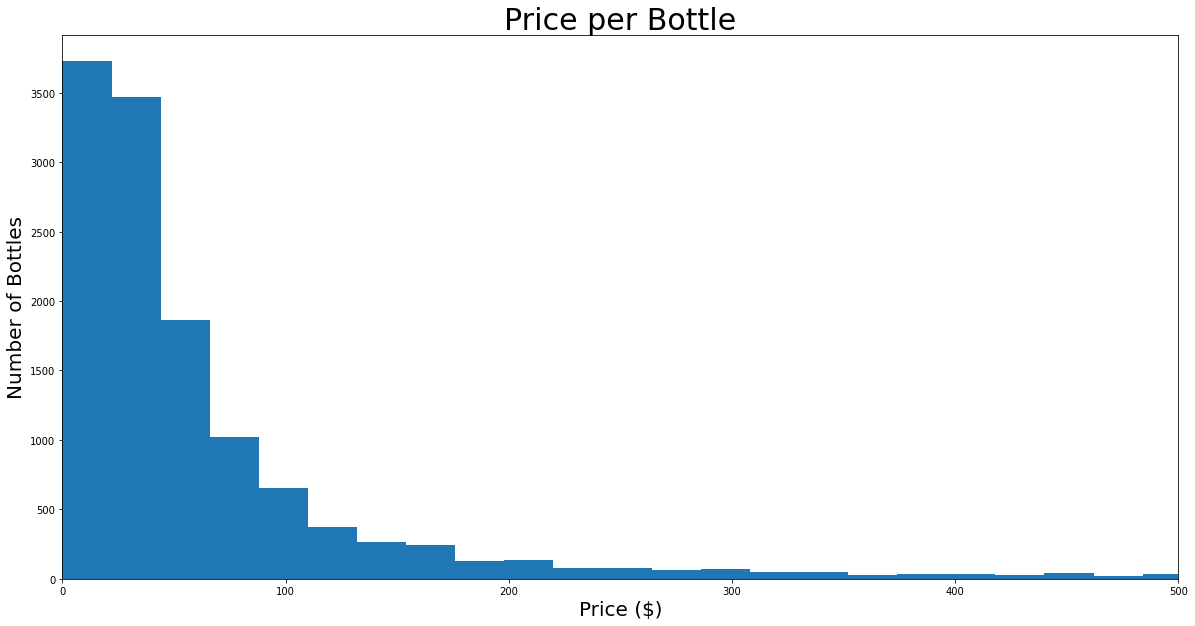

In [121]:
plt.figure(figsize=(20,10));
# sns.distplot(all_wines['price']);
all_wines['price'].hist(bins=1000, grid=False)
plt.title('Price per Bottle', fontsize=30)
plt.xlabel('Price ($)', fontsize=20)
plt.ylabel('Number of Bottles', fontsize=20)
plt.xlim([0, 500]);

In [122]:
all_wines.isnull().sum()

name           0
producer       0
vintage        0
bottle_size    0
color          0
price          0
country        0
region         0
url            0
description    0
grape          0
subregion      0
dtype: int64

In [123]:
# all_wines.to_csv('../data/all_clean_wines.csv', index=False)

# Clean for Modeling

### Clean text for modeling
1. Can do a complete cleaning on `description`
2. For `name` be more cautions<br> 
    -Chambers has producer, region, grape, subregion information in this column<br>
    -Wine.com has producer information in `name` and subregion information in `region`

In [124]:
stop_words = stopwords.words('english')
stop_words.append('aka')
stop_words.extend(('a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q',
                  'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'nv'))


In [125]:
def clean_text(text):
    # Cast text as string (floats in body text)
    text = str(text)
    
#     Lowercase all words
    lower = text.lower()
    
    # Tokenizes by whitespace
    letters_only = re.sub('[^a-zA-Z]', ' ', lower)
    
    tokenizer = RegexpTokenizer('\s+', gaps=True)
    tokens = tokenizer.tokenize(letters_only)
    
    stops = set(stop_words)
    tokens_stops = [w for w in tokens if w not in stop_words]
     
    
    # Return tokens stripped of trailing punctuation
    return (' '.join(tokens_stops))

Keep `country` and `country_clean` <br>
One for the model and one for EDA

In [126]:
# all_wines['name'] = all_wines['name'].map(clean_text)
all_wines['description_clean'] = all_wines['description'].map(clean_text)
all_wines['color'] = all_wines['color'].map(clean_text)
all_wines['country_clean'] = all_wines['country'].map(clean_text)

In [167]:
print('all wines', len(all_wines['country_clean'].unique()))

all wines 35


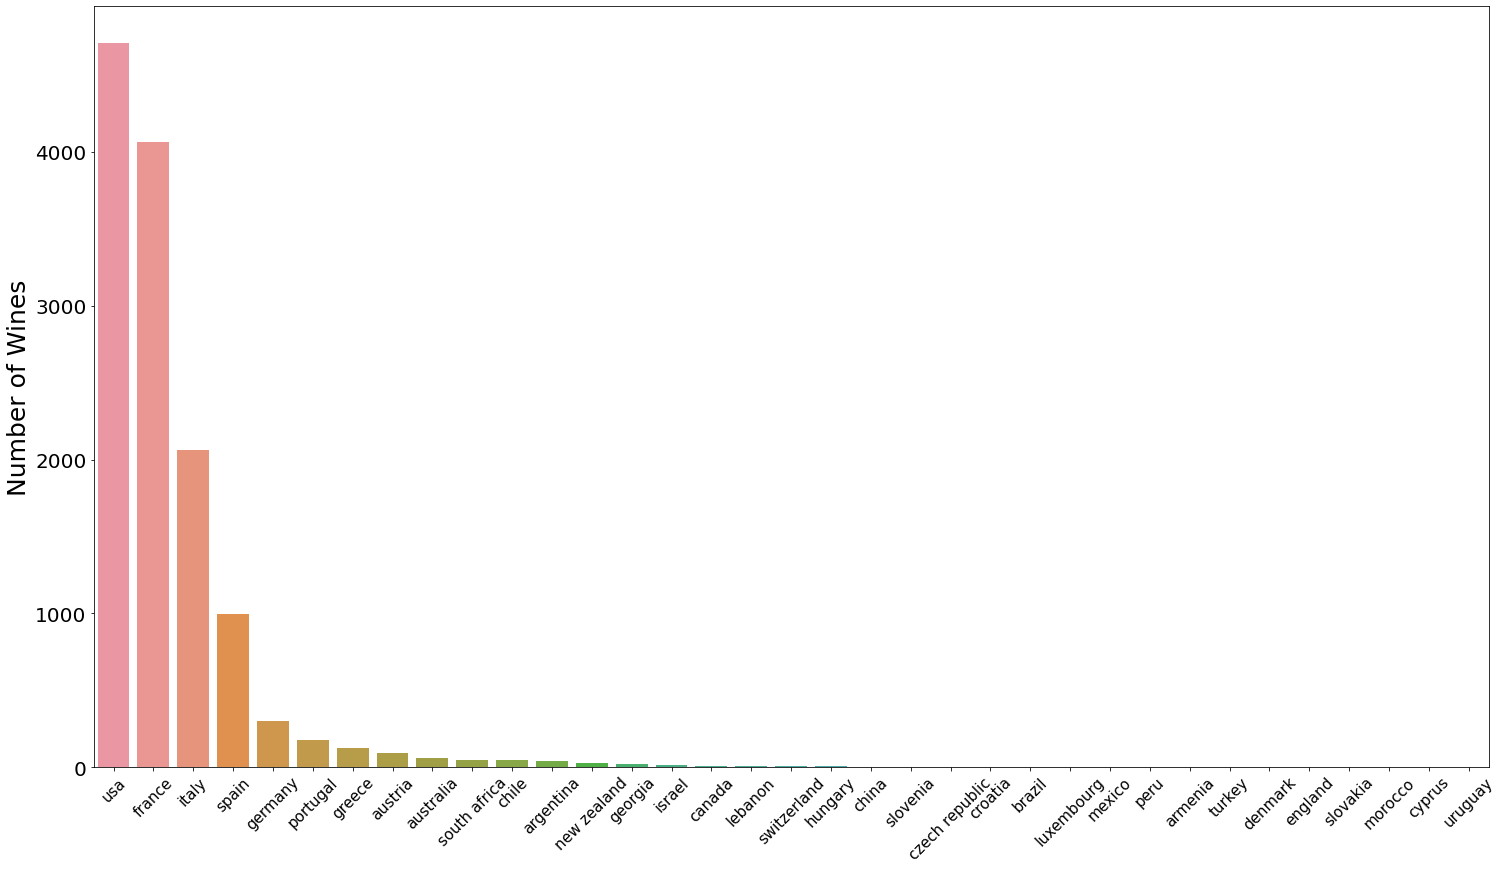

In [176]:
x = all_wines['country_clean'].value_counts()
y = x.sort_index()
plt.figure(figsize=(25,14))
chart = sns.barplot(x.index, x.values);
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);
# plt.title('Wines by Country', fontsize=30);
plt.ylabel('Number of Wines', fontsize=25);
plt.yticks(fontsize=20);
# plt.xlabel('Country', fontsize=25);
plt.xticks(fontsize=15);

In [127]:
def clean_text_name(text):
    # Cast text as string (floats in body text)
    text = str(text)
    
#     Lowercase all words
#     lower = text.lower()
    
    # Tokenizes by whitespace
#     letters_only = re.sub('[^a-zA-Z]', ' ', lower)
    
    tokenizer = RegexpTokenizer('\s+', gaps=True)
    tokens = tokenizer.tokenize(text)
    
    stops = set(stop_words)
    tokens_stops = [w for w in tokens if w not in stop_words]
     
    
    # Return tokens stripped of trailing punctuation
    return (' '.join(tokens_stops))

In [128]:
# Clean name differently-leave numbers and symbols
all_wines['name'] = all_wines['name'].map(clean_text_name)

In [129]:
all_wines['region'] = [str(words).lower() for words in all_wines['region']]
all_wines['subregion'] = [str(words).lower() for words in all_wines['subregion']]
all_wines['grape'] = [str(words).lower() for words in all_wines['grape']]

In [130]:
all_wines.tail()

,name,producer,vintage,bottle_size,color,price,country,region,url,description,grape,subregion,description_clean,country_clean
8268,Biblia Chora Areti White,0,2018,750,white,28,greece,"macedonia, greece",https://www.wine.com/product/biblia-chora-aret...,The Areti is produced from the Assyrtiko varie...,assyrtiko,0,areti produced assyrtiko varietal cultivated b...,greece
8269,Alexakis Assyrtiko,0,2019,750,white,18,greece,greece,https://www.wine.com/product/alexakis-assyrtik...,Bright yellow color with green hues. The bouqu...,assyrtiko,0,bright yellow color green hues bouquet display...,greece
8270,Domaine Zafeirakis Chardonnay,0,2018,750,white,22,greece,greece,https://www.wine.com/product/domaine-zafeiraki...,Domaine Zafeirakis Chardonnay 2018,chardonnay,0,domaine zafeirakis chardonnay,greece
8271,Gaia Monograph Assyrtiko,0,2019,750,white,18,greece,"nemea, greece",https://www.wine.com/product/gaia-monograph-as...,"A youthful, intensely fruity Assyrtiko, with a...",assyrtiko,0,youthful intensely fruity assyrtiko bouquet ho...,greece
8272,Ktima Pavlidis Thema White,0,2019,750,white,21,greece,greece,https://www.wine.com/product/ktima-pavlidis-th...,This fragrant white possesses a multilayered b...,other white blends,0,fragrant white possesses multilayered bouquet ...,greece


Combined all text based columns for the models so key words from other columns will be included in the recommender. As null values are set to 0, removed all non letters from this new column. 

In [131]:
all_wines['text'] = all_wines['region'] + all_wines['subregion'] + ' ' + all_wines['color'] + ' ' + all_wines['country'] + ' ' + all_wines['description_clean']
all_wines['text'] = [re.sub('[0123456789\.]','', row) for row in all_wines['text']]
all_wines['text']

0       franken white Germany made silvaner white wine...
1       franken red Germany made schwartz riesling pin...
2       rheingau white Germany sometimes want drink wi...
3       ribeira sacra red Spain fuga menciajust barely...
4       calabriacirò red Italy wine distinct alluring ...
5       mosel-saar-ruwermittel-mosel white Germany win...
6        red Armenia minimalist label much information...
7       bierzo red Spain straightforward wine berry ch...
9       languedoc-roussillon red France medium bodied ...
10      languedoc-roussillon white France unoaked char...
11      corsica red France jean charles abbatucci quit...
12      trentino-alto adigealto adige white Italy much...
13      trentino-alto adigealto adige white Italy pala...
14      california red USA balou name favorite jungle ...
15      california red USA made petit verdot yes borde...
16      mendoza red Argentina complex aromas plum blac...
17      piedmontbarbaresco red Italy cuv comes ada nad...
18       red P

Count words

In [14]:
def word_count(series):
    list_tokens = [w.lower() for w in series]
    string_tokens = str(list_tokens)
    return string_tokens

In [133]:
def top_words(series):
    clean_tokens = word_count(series)
    count = Counter(clean_tokens.split())
    return count.most_common(20)

In [15]:
# look for words that should be added to stopwords
top_words(all_wines['description_clean'])

NameError: name 'top_words' is not defined

In [135]:
# all_wines.to_csv('../data/test_wines.csv', index=False)

In [136]:
pd.read_csv('../data/test_wines.csv').isnull().sum()

name                   0
producer               0
vintage              224
bottle_size            0
color                193
price                  0
country                0
region                 0
url                    0
description            0
grape                  0
subregion              0
description_clean      0
country_clean          0
text                   0
dtype: int64